# Libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from functools import partial
from collections import Counter
import seaborn as sns

from joblib import load

# modeling
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# ignore warnings
import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Get dataset

In [3]:
# get pickle file
providers = load('./data/Providers_Final.pkl')
providers.set_index('Provider', inplace=True)

In [4]:
providers

,PotentialFraud,Perc_Outpatient,DualPatientProvider,Perc_DualPatientType,Ratio_ClaimsPerPatient,Ratio_ClaimsPerAttPhys,Perc_ClaimsPerTopFraudState,Perc_HasTop5AdmtCode,PatientsPerAttPhys,PatientsPerOperPhys,PatientsPerOthPhys,Perc_MultHospAttPhys,Perc_MultHospOperPhys,Perc_MultHospOtherPhys,IP_Perc_Duplicates,IP_Count_UniquePatients,IP_Count_UniqueState,IP_Mean_AgeAtClaim,IP_Perc_HasDied,IP_Perc_GenderZero,IP_Perc_RaceOne,IP_Perc_RaceTwo,IP_Perc_RaceThree,IP_Mean_NumChronicConds,IP_Perc_Alzheimers_Chronic,IP_Perc_Cancer_Chronic,IP_Perc_Depression_Chronic,IP_Perc_Diabetes_Chronic,IP_Perc_HeartFailure_Chronic,IP_Perc_IschemicHeart_Chronic,IP_Perc_KidneyDisease_Chronic,IP_Perc_ObstrPulmonary_Chronic,IP_Perc_Osteoporosis_Chronic,IP_Perc_RheumatoidArthritis_Chronic,IP_Perc_Stroke_Chronic,IP_Perc_HasRenalDisease,IP_Mean_ClaimDuration,IP_Mean_AdmitDuration,IP_Mean_NoOfMonths_PartACov,IP_Mean_NoOfMonths_PartBCov,IP_Mean_ClaimCost,IP_Mean_DailyClaimCost,IP_Mean_DeductibleAmtPaid,IP_Mean_InscClaimAmtReimbursed,IP_Mean_InsReimbursementRatio,IP_Mean_AnnualDeductibleAmt,IP_Mean_AnnualReimbursementAmt,IP_Perc_No_ProcCode,IP_Perc_HasAllPhys,IP_Perc_HasNoPhys,IP_Perc_MultHosp,OP_Perc_Duplicates,OP_Count_UniquePatients,OP_Count_UniqueState,OP_Mean_AgeAtClaim,OP_Perc_HasDied,OP_Perc_GenderZero,OP_Perc_RaceOne,OP_Perc_RaceTwo,OP_Perc_RaceThree,OP_Mean_NumChronicConds,OP_Perc_Alzheimers_Chronic,OP_Perc_Cancer_Chronic,OP_Perc_Depression_Chronic,OP_Perc_Diabetes_Chronic,OP_Perc_HeartFailure_Chronic,OP_Perc_IschemicHeart_Chronic,OP_Perc_KidneyDisease_Chronic,OP_Perc_ObstrPulmonary_Chronic,OP_Perc_Osteoporosis_Chronic,OP_Perc_RheumatoidArthritis_Chronic,OP_Perc_Stroke_Chronic,OP_Perc_HasRenalDisease,OP_Mean_ClaimDuration,OP_Mean_NoOfMonths_PartACov,OP_Mean_NoOfMonths_PartBCov,OP_Mean_ClaimCost,OP_Mean_DailyClaimCost,OP_Mean_DeductibleAmtPaid,OP_Mean_InscClaimAmtReimbursed,OP_Mean_InsReimbursementRatio,OP_Mean_AnnualDeductibleAmt,OP_Mean_AnnualReimbursementAmt,OP_Perc_No_DiagCode,OP_Perc_HasAllPhys,OP_Perc_HasNoPhys,OP_Perc_MultHosp
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51001,0,0.800000,1.0,0.400000,1.041667,1.785714,0.0,0.040000,10,19,16,0.240000,0.040000,0.000000,0.000000,5.0,1.0,77.600000,0.000000,0.400000,1.000000,0.000000,0.0,6.000000,0.400000,0.200000,0.800000,0.800000,0.800000,0.800000,0.800000,0.400000,0.000000,0.600000,0.400000,0.400000,6.000000,6.000000,12.000000,12.000000,20468.000000,4077.360000,1068.0,19400.000000,0.878279,897.120000,17606.000000,0.600000,0.2,0.0,0.160000,0.550000,19.0,1.0,77.950000,0.000000,0.350000,0.800000,0.200000,0.000000,5.450000,0.650000,0.200000,0.250000,0.850000,0.750000,0.950000,0.650000,0.400000,0.300000,0.250000,0.200000,0.300000,1.550000,12.000000,12.000000,382.000000,307.000000,0.000000,382.000000,1.000000,463.920000,2615.200000,0.000000,0.050000,0.000000,0.920000
PRV51003,1,0.530303,1.0,0.500000,1.128205,3.000000,0.0,0.060606,73,110,95,0.007576,0.000000,0.000000,0.016129,53.0,3.0,69.935484,0.016129,0.338710,0.790323,0.209677,0.0,4.919355,0.516129,0.112903,0.403226,0.790323,0.580645,0.887097,0.629032,0.370968,0.209677,0.306452,0.112903,0.274194,6.161290,6.161290,11.806452,11.806452,10309.935484,2384.941628,1068.0,9241.935484,0.821059,931.424242,7568.181818,0.370968,0.0,0.0,0.045455,0.357143,66.0,3.0,68.371429,0.000000,0.471429,0.828571,0.157143,0.000000,4.214286,0.342857,0.042857,0.414286,0.728571,0.628571,0.814286,0.357143,0.257143,0.285714,0.271429,0.071429,0.171429,3.357143,11.828571,11.928571,467.714286,336.440760,1.000000,466.714286,0.994032,737.121212,2678.181818,0.000000,0.057143,0.000000,0.818182
PRV51004,0,1.000000,0.0,0.208054,1.079710,3.921053,0.0,0.013423,100,119,112,0.167785,0.013423,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000

# Train test split

In [5]:
scores = providers.drop(['PotentialFraud'], axis=1)
scores = pd.DataFrame(scores, columns = scores.columns)
decision = providers["PotentialFraud"]

Xtrain, Xtest, ytrain, ytest = train_test_split(scores, decision, 
                                                test_size = .30, random_state=0, 
                                                stratify = decision)

# we want to normalize and down/upsample after splitting.

In [6]:
providers_test = pd.concat([ytrain, Xtrain], axis=1)
display(providers_test)
display(providers_test['PotentialFraud'].value_counts())

,PotentialFraud,Perc_Outpatient,DualPatientProvider,Perc_DualPatientType,Ratio_ClaimsPerPatient,Ratio_ClaimsPerAttPhys,Perc_ClaimsPerTopFraudState,Perc_HasTop5AdmtCode,PatientsPerAttPhys,PatientsPerOperPhys,PatientsPerOthPhys,Perc_MultHospAttPhys,Perc_MultHospOperPhys,Perc_MultHospOtherPhys,IP_Perc_Duplicates,IP_Count_UniquePatients,IP_Count_UniqueState,IP_Mean_AgeAtClaim,IP_Perc_HasDied,IP_Perc_GenderZero,IP_Perc_RaceOne,IP_Perc_RaceTwo,IP_Perc_RaceThree,IP_Mean_NumChronicConds,IP_Perc_Alzheimers_Chronic,IP_Perc_Cancer_Chronic,IP_Perc_Depression_Chronic,IP_Perc_Diabetes_Chronic,IP_Perc_HeartFailure_Chronic,IP_Perc_IschemicHeart_Chronic,IP_Perc_KidneyDisease_Chronic,IP_Perc_ObstrPulmonary_Chronic,IP_Perc_Osteoporosis_Chronic,IP_Perc_RheumatoidArthritis_Chronic,IP_Perc_Stroke_Chronic,IP_Perc_HasRenalDisease,IP_Mean_ClaimDuration,IP_Mean_AdmitDuration,IP_Mean_NoOfMonths_PartACov,IP_Mean_NoOfMonths_PartBCov,IP_Mean_ClaimCost,IP_Mean_DailyClaimCost,IP_Mean_DeductibleAmtPaid,IP_Mean_InscClaimAmtReimbursed,IP_Mean_InsReimbursementRatio,IP_Mean_AnnualDeductibleAmt,IP_Mean_AnnualReimbursementAmt,IP_Perc_No_ProcCode,IP_Perc_HasAllPhys,IP_Perc_HasNoPhys,IP_Perc_MultHosp,OP_Perc_Duplicates,OP_Count_UniquePatients,OP_Count_UniqueState,OP_Mean_AgeAtClaim,OP_Perc_HasDied,OP_Perc_GenderZero,OP_Perc_RaceOne,OP_Perc_RaceTwo,OP_Perc_RaceThree,OP_Mean_NumChronicConds,OP_Perc_Alzheimers_Chronic,OP_Perc_Cancer_Chronic,OP_Perc_Depression_Chronic,OP_Perc_Diabetes_Chronic,OP_Perc_HeartFailure_Chronic,OP_Perc_IschemicHeart_Chronic,OP_Perc_KidneyDisease_Chronic,OP_Perc_ObstrPulmonary_Chronic,OP_Perc_Osteoporosis_Chronic,OP_Perc_RheumatoidArthritis_Chronic,OP_Perc_Stroke_Chronic,OP_Perc_HasRenalDisease,OP_Mean_ClaimDuration,OP_Mean_NoOfMonths_PartACov,OP_Mean_NoOfMonths_PartBCov,OP_Mean_ClaimCost,OP_Mean_DailyClaimCost,OP_Mean_DeductibleAmtPaid,OP_Mean_InscClaimAmtReimbursed,OP_Mean_InsReimbursementRatio,OP_Mean_AnnualDeductibleAmt,OP_Mean_AnnualReimbursementAmt,OP_Perc_No_DiagCode,OP_Perc_HasAllPhys,OP_Perc_HasNoPhys,OP_Perc_MultHosp
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV52041,1,1.000000,0.0,0.245623,2.053377,235.625000,0.037666,0.021751,910,911,916,0.115119,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,389.901326,3762.005305,0.000000,0.000000,0.0,0.041910,0.430960,918.0,17.0,74.118302,0.004775,0.410610,0.666667,0.000000,0.142857,4.338462,0.363395,0.138462,0.406897,0.663660,0.592573,0.766578,0.372414,0.328912,0.327321,0.283820,0.094430,0.198939,2.445093,11.980371,11.970822,323.856764,242.538986,2.912467,320.944297,0.984813,653.856764,2449.395225,0.016446,0.093369,0.003714,0.846154
PRV51771,0,1.000000,0.0,0.425000,1.176471,40.000000,1.000000,0.050000,33,33,33,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,507.300000,3096.000000,0.000000,0.000000,0.0,0.050000,0.525000,34.0,1.0,73.725000,0.000000,0.325000,1.000000,0.000000,0.000000,3.525000,0.325000,0.100000,0.375000,0.575000,0.475000,0.625000,0.325000,0.325000,0.200000,0.150000,0.050000,0.175000,1.675000,11.700000,12.000000,214.750000,143.321429,1.500000,213.250000,0.974969,632.500000,1709.250000,0.000000,0.100000,0.000000,0.925000
PRV52079,0,0.787879,1.0,0.272727,1.064516,1.500000,0.000000,0.030303,9,20,26,0.090909,0.030303,0.000000,0.142857,7.0,2.0,68.714286,0.0,0.285714,0.571429,0.071429,0.214286,5.000000,0.571429,0.000000,0.285714,1.000000,0.428571,0.857143,0.571429,0.285714,0.428571,0.428571,0.142857,0.142857,7.571429,7.571429,12.000000,12.0,6568.000000,1817.212600,1068.0,5500.000000,0.73

0    3433
1     354
Name: PotentialFraud, dtype: int64

# Stardardize and Down/upsampling

In [28]:
mm_scaler = preprocessing.MinMaxScaler()
Xtrain = mm_scaler.fit_transform(Xtrain)
Xtest = mm_scaler.transform(Xtest)

In [7]:
### UPSAMPLING
# Separate majority and minority classes
df_majority = providers_test[providers_test.PotentialFraud==0]
df_minority = providers_test[providers_test.PotentialFraud==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=3433,    # to match majority class
                                 random_state=0) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
display(df_upsampled.PotentialFraud.value_counts())

# separate into Xtrain and Ytrain
Xtrain_upsampled = df_upsampled.drop(['PotentialFraud'], axis=1)
ytrain_upsampled = df_upsampled['PotentialFraud']

1    3433
0    3433
Name: PotentialFraud, dtype: int64

In [21]:
mm_scaler = preprocessing.MinMaxScaler()
Xtrain_upsampled = mm_scaler.fit_transform(Xtrain_upsampled)
Xtest_upsampled = mm_scaler.transform(Xtest)

len(Xtrain_upsampled)

6866

In [23]:
### DOWNSAMPLING
# Separate majority and minority classes
df_majority = providers_test[providers_test.PotentialFraud==0]
df_minority = providers_test[providers_test.PotentialFraud==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=354,     # to match minority class
                                 random_state=0) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
display(df_downsampled.PotentialFraud.value_counts())

# separate into Xtrain and Ytrain
Xtrain_downsampled = df_downsampled.drop(['PotentialFraud'], axis=1)
ytrain_downsampled = df_downsampled['PotentialFraud']

1    354
0    354
Name: PotentialFraud, dtype: int64

In [24]:
mm_scaler = preprocessing.MinMaxScaler()
Xtrain_downsampled = mm_scaler.fit_transform(Xtrain_downsampled)
Xtest_downsampled = mm_scaler.transform(Xtest)

len(Xtrain_downsampled)

708

# Modeling


In [12]:
# some functions that will be used in modeling
def plot_feature_importances(model):
    n_features = scores.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), scores_cols.to_numpy()) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    

# Stratified Cross Validation needs to be applied 
skf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

### train a simple classifier model and handling imbalanced classes

In [35]:
logreg = LogisticRegression(random_state=0, class_weight='balanced', penalty='l1', solver='liblinear')
param_grid = {'C': np.logspace(-3,1,100)}
logregCV = GridSearchCV(logreg, param_grid = param_grid, scoring='recall',cv=skf).fit(Xtrain,ytrain)

print("Best parameters: {}".format(logregCV.best_params_))
print("Best cross-validation score: {:.2f}".format(logregCV.best_score_))
print("Best estimator:\n{}".format(logregCV.best_estimator_))

Best parameters: {'C': 0.09545484566618342}
Best cross-validation score: 0.91
Best estimator:
LogisticRegression(C=0.09545484566618342, class_weight='balanced', penalty='l1',
                   random_state=0, solver='liblinear')


In [14]:
display(recall_score(ytrain, logregCV.best_estimator_.predict(Xtrain)))
display(recall_score(ytest, logregCV.best_estimator_.predict(Xtest)))

0.9161083600349549

0.9078947368421053

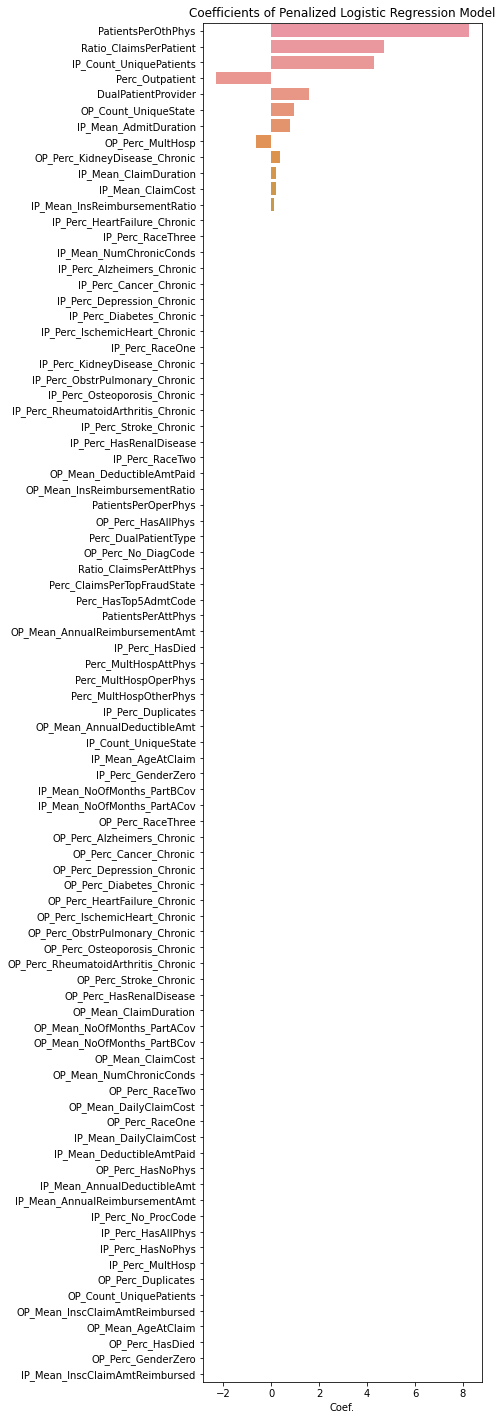

In [15]:
logistic_coef = pd.DataFrame(logregCV.best_estimator_.coef_.T, index = scores.columns).rename(columns = {0:"Coef."})
logistic_coef = logistic_coef.reindex(logistic_coef["Coef."].abs().sort_values(ascending = False).index)
plt.figure(figsize = (5,25))
sns.barplot(data = logistic_coef.reset_index(), x = 'Coef.', y = 'index');
plt.title('Coefficients of Penalized Logistic Regression Model');
plt.ylabel('');

In [25]:
logreg = LogisticRegression(random_state=0, class_weight='balanced', penalty='l1', solver='liblinear')
param_grid = {'C': np.logspace(-3,1,100)}
logregCV = GridSearchCV(logreg, param_grid = param_grid, scoring='recall',cv=skf).fit(Xtrain_downsampled,ytrain_downsampled)

print("Best parameters: {}".format(logregCV.best_params_))
print("Best cross-validation score: {:.2f}".format(logregCV.best_score_))
print("Best estimator:\n{}".format(logregCV.best_estimator_))

Best parameters: {'C': 0.31992671377973847}
Best cross-validation score: 0.89
Best estimator:
LogisticRegression(C=0.31992671377973847, class_weight='balanced', penalty='l1',
                   random_state=0, solver='liblinear')


In [26]:
display(recall_score(ytrain_downsampled, logregCV.best_estimator_.predict(Xtrain_downsampled)))
display(recall_score(ytest, logregCV.best_estimator_.predict(Xtest_downsampled)))

0.9152542372881356

0.8947368421052632

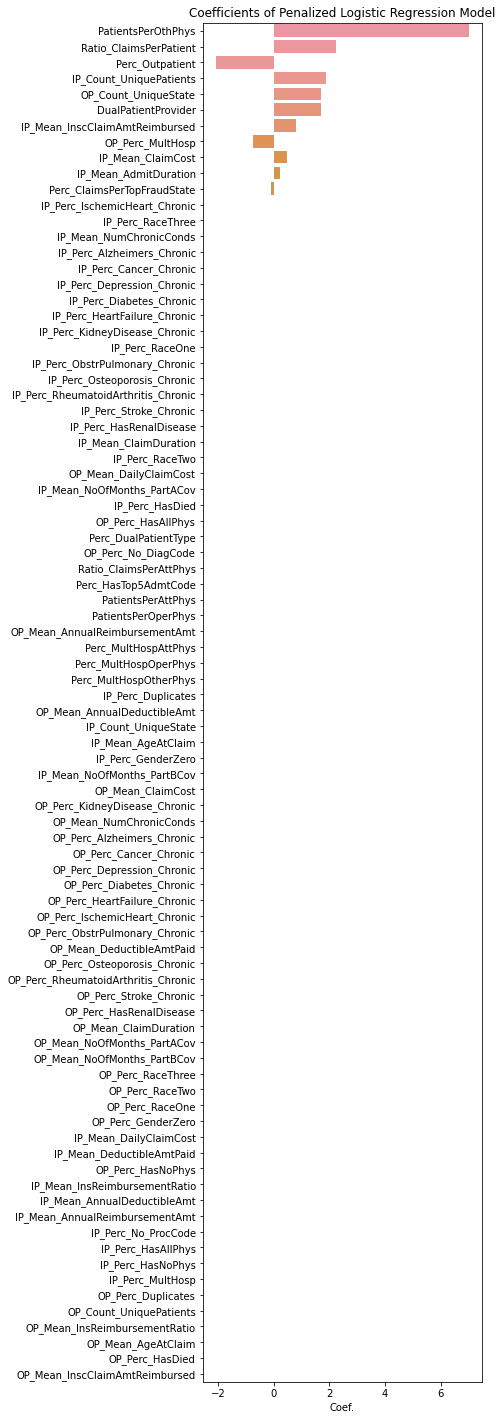

In [27]:
logistic_coef = pd.DataFrame(logregCV.best_estimator_.coef_.T, index = scores.columns).rename(columns = {0:"Coef."})
logistic_coef = logistic_coef.reindex(logistic_coef["Coef."].abs().sort_values(ascending = False).index)
plt.figure(figsize = (5,25))
sns.barplot(data = logistic_coef.reset_index(), x = 'Coef.', y = 'index');
plt.title('Coefficients of Penalized Logistic Regression Model');
plt.ylabel('');

### decision tree

In [ ]:
# tree = DecisionTreeClassifier(max_depth=4, random_state=0) 
# tree.fit(Xtrain, ytrain)
# print("Accuracy on training set: {:.3f}".format(tree.score(Xtrain, ytrain))) 
# print("Accuracy on test set: {:.3f}".format(tree.score(Xtest, ytest)))

# display(recall_score(ytrain, tree.predict(Xtrain)))
# display(recall_score(ytest, tree.predict(Xtest)))

In [ ]:
# plt.figure(figsize=(10,20))
# plot_feature_importances(tree)

### random forest

In [ ]:
param_grid = {
    'n_estimators': [200, 600, 1000, 2000],
    'max_features': ['auto', 'log2'],
    'min_samples_split': [2, 4, 6]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=0, 
                                                  class_weight='balanced'), 
                           param_grid, cv=skf, scoring='recall')
grid_search.fit(Xtrain, ytrain)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

In [29]:
param_grid = {
    'n_estimators': [200, 600, 1000, 2000],
    'max_features': ['auto', 'log2'],
    'min_samples_split': [2, 4, 6]
}

grid_search = RandomizedSearchCV(RandomForestClassifier(random_state=0, 
                                                  class_weight='balanced'), 
                           param_grid, cv=skf, scoring='recall', random_state=0)
grid_search.fit(Xtrain, ytrain)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best parameters: {'n_estimators': 1000, 'min_samples_split': 6, 'max_features': 'log2'}
Best cross-validation score: 0.42
Best estimator:
RandomForestClassifier(class_weight='balanced', max_features='log2',
                       min_samples_split=6, n_estimators=1000, random_state=0)


In [30]:
display(recall_score(ytrain, grid_search.best_estimator_.predict(Xtrain)))
display(recall_score(ytest, grid_search.best_estimator_.predict(Xtest)))

1.0

0.4605263157894737

In [ ]:
plt.figure(figsize=(10,20))
plot_feature_importances(grid_search.best_estimator_)

### gradient boosting

In [33]:
gb_param_grid = {
    'learning_rate':[0.1,0.05,0.01], 
    'n_estimators':[100,500,1000],
    'max_depth':[2,4,6]
}

gb_grid_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=0), 
                                    gb_param_grid, 
                                    cv=skf, 
                                    scoring='recall', 
                                    random_state=0)
gb_grid_search.fit(Xtrain_upsampled, ytrain_upsampled)

print("Best parameters: {}".format(gb_grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(gb_grid_search.best_score_))
print("Best estimator:\n{}".format(gb_grid_search.best_estimator_))

Best parameters: {'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.05}
Best cross-validation score: 1.00
Best estimator:
GradientBoostingClassifier(learning_rate=0.05, max_depth=4, n_estimators=1000,
                           random_state=0)


In [34]:
display(recall_score(ytrain_upsampled, gb_grid_search.best_estimator_.predict(Xtrain_upsampled)))
display(recall_score(ytest, gb_grid_search.best_estimator_.predict(Xtest_upsampled)))

1.0

0.26973684210526316

In [ ]:
plt.figure(figsize=(10,20))
plot_feature_importances(gb_grid_search.best_estimator_)

In [ ]:
gb_param_grid = {
    'learning_rate':[0.1,0.05,0.01], 
    'n_estimators':[100,500,1000],
    'max_depth':[2,4,6]
}

gb_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=0), gb_param_grid, cv=3, scoring='recall')
gb_grid_search.fit(Xtrain_downsampled, ytrain_downsampled)

print("Best parameters: {}".format(gb_grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(gb_grid_search.best_score_))
print("Best estimator:\n{}".format(gb_grid_search.best_estimator_))

In [ ]:
display(recall_score(ytrain_downsampled, gb_grid_search.best_estimator_.predict(Xtrain_downsampled)))
display(recall_score(ytest, gb_grid_search.best_estimator_.predict(Xtest_downsampled)))

### support vector machine

In [ ]:
svc = SVC(C=1000) 
svc.fit(Xtrain, ytrain)

print("Accuracy on training set: {:.2f}".format(svc.score(Xtrain, ytrain))) 
print("Accuracy on test set: {:.2f}".format(svc.score(Xtest, ytest)))

In [ ]:
gb_param_grid = {
    'learning_rate':[0.1,0.05,0.01], 
    'n_estimators':[100,500,1000],
    'max_depth':[2,4,6]
}

gb_grid_search = GridSearchCV(SVC(random_state=0), gb_param_grid, cv=3, scoring='recall')
gb_grid_search.fit(Xtrain_res, ytrain_res)

print("Best parameters: {}".format(gb_grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(gb_grid_search.best_score_))
print("Best estimator:\n{}".format(gb_grid_search.best_estimator_))